In [1]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [2]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [4]:
path="datasets/child_PreGen_data/"
randomiser = np.random.RandomState(123)

In [5]:
for r, d, f in os.walk(path):
    all_child = f

In [6]:
def generate_batch(child_batch):
    np_images=[]
    for child in child_batch:
        res = np.array(Image.open(path+child))
        np_images.append(res)
    return np_images

In [7]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.0001
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 30
batch = 64

In [8]:
def pre_gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [9]:
OUTPUT_CHANNELS = 3

In [10]:
def Pre_Generator():
    
    up_stack_noise = [
    pre_gen_upsample(64,4,apply_batchnorm=True), #8x8x64
    pre_gen_upsample(32,4,apply_batchnorm=True), #16x16x64
    pre_gen_upsample(32,4,apply_batchnorm=True)  #32x32x32
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')
    
    noise = tf.keras.layers.Input(shape=(4,4,64))
    
    x = noise
    for up in up_stack_noise:
        x = up(x)
#     print(x.shape)
    output = last(x)
#     print(output.shape)
    return tf.keras.Model(inputs=noise, outputs=output)

In [11]:
def pre_disc_downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [12]:
def Pre_Discriminator():
    
    down_stack_image = [
    pre_disc_downsample(32,4,apply_batchnorm=False), #32x32x32
    pre_disc_downsample(64,4,apply_batchnorm=True), #16x16x64
    pre_disc_downsample(64,4,apply_batchnorm=True),  #8x8x64
    pre_disc_downsample(256,4,apply_batchnorm=False) #4x4x256
        
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')
    
    image = tf.keras.layers.Input(shape=(64,64,3))
    print(image.shape)
    x = image
    for down in down_stack_image:
        x = down(x)
#         print(x.shape)
    output = last(x)
#     print(output.shape)

    return tf.keras.Model(inputs=image, outputs=output)

In [13]:
bce = tf.keras.losses.BinaryCrossentropy()

In [14]:
pre_gen_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1, beta_2= b2)
pre_disc_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1, beta_2= b2)

In [15]:
def train_PreGAN(noise_batch, target_batch, b_size):
    with tf.GradientTape() as pre_gen_tape ,tf.GradientTape() as pre_disc_tape:
        
        pre_gen_outputs = pre_gen(noise_batch, training=True)
        disc_pre_gen_out = pre_disc(pre_gen_outputs, training=True)
        disc_target_out = pre_disc(target_batch,training=True)
        ones = tf.ones_like(disc_pre_gen_out)
        zeros = tf.zeros_like(disc_pre_gen_out)
        
        disc_loss = bce(ones,disc_target_out) + bce(zeros,disc_pre_gen_out)
        gen_loss = bce(ones,disc_pre_gen_out)
        
    
#     print("GEN_LOSS: ",tensor_to_array(gen_loss))
#     print("DISC_LOSS: ",tensor_to_array(disc_loss))
    
    #calculate gradients
    pre_gen_gradients = pre_gen_tape.gradient(gen_loss,pre_gen.trainable_variables)
    pre_disc_gradients = pre_disc_tape.gradient(disc_loss,pre_disc.trainable_variables)
    
    #apply gradients on optimizer
    pre_gen_optimizer.apply_gradients(zip(pre_gen_gradients,pre_gen.trainable_variables))
    pre_disc_optimizer.apply_gradients(zip(pre_disc_gradients,pre_disc.trainable_variables))
    return gen_loss, disc_loss

In [16]:
gen_loss_history = []
disc_loss_history = []
def fit_encoder(all_child, epochs, batch):
    no_of_iter = len(all_child)//batch
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        gen_epoch_loss = 0.0
        disc_epoch_loss = 0.0
        
        for i in range(no_of_iter):
            batch_data = np.asarray(generate_batch(all_child[i*batch:(i+1)*batch]))
            child_batch= batch_data / 255 * 2 -1
            
            
#             print("Generated batch", batch_data.shape)
            
            noise = tf.random.normal((batch,4,4,64),mean= 0.0, stddev=1.0)

            gen_batch_loss, disc_batch_loss = train_PreGAN(noise, child_batch,batch)
            gen_epoch_loss += gen_batch_loss
            disc_epoch_loss += disc_batch_loss
#             print("Trained for batch %d/%d"%(i+1,(len(all_child)//batch)))
            
        gen_epoch_loss /= no_of_iter
        disc_epoch_loss /= no_of_iter
        
        print("GEN_EPOCH_LOSS:",gen_epoch_loss)
        print("DISC_EPOCH_LOSS",disc_epoch_loss)
        
        if (epoch%1 == 0):
            gen_loss_history.append(gen_epoch_loss)
            disc_loss_history.append(disc_epoch_loss)
        
        pre_gen.save_weights(filepath='checkpoint/pre_gan_weights/epoch_%d_preG.pth' % (epoch))
        pre_disc.save_weights(filepath='checkpoint/pre_gan_weights/epoch_%d_preD.pth' % (epoch))
        
        
    print("______________________________TRAINING COMPLETED_______________________________")

In [17]:
pre_gen = Pre_Generator()
pre_disc = Pre_Discriminator()
with tf.device('/gpu:0'):
    fit_encoder(all_child, EPOCHS,batch)
    gen_loss_history = tf.stack(gen_loss_history)
    disc_loss_history = tf.stack(disc_loss_history)

(None, 64, 64, 3)
______________________________EPOCH 1_______________________________

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

GEN_EPOCH_LOSS: tf.Tensor(1.0009227, shape=(), dtype=float32)
DISC_EPOCH_LOSS tf.Tensor(0.95954084, shape=(), dtype=float32)
______________________________EPOCH 2_______________________________
GEN_EPOCH_LOSS: tf.Tensor(2.0685318, shape=(), dtype=float32)
DISC_EPOCH_LOSS tf.Tensor(0.38219282, shape=(), dtype=float32)
______________________________EPOCH 3_______________________________
GEN_EPOCH_LOSS: tf.Tensor(3.17289

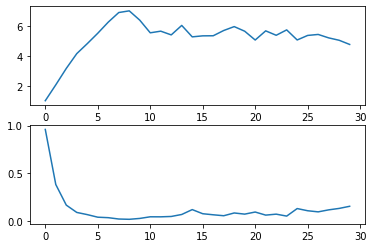

In [18]:
gen_loss_history = gen_loss_history.numpy()
disc_loss_history = disc_loss_history.numpy()
#add plot for this
plt.subplot(2,1,1)
plt.plot(gen_loss_history)
plt.subplot(2,1,2)
plt.plot(disc_loss_history)


In [ ]:
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

In [ ]:
pre_gen = Pre_Generator()
pre_disc = Pre_Discriminator()

with tf.device('/cpu:0'):
    gen_output = pre_gen(noise, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))

In [ ]:
pre_gen.load_weights('checkpoint/pre_gan_weights/epoch_20_preG.pth')
pre_disc.load_weights('checkpoint/pre_gan_weights/epoch_20_preD.pth')

with tf.device('/cpu:0'):
    gen_output = pre_gen(noise, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))

In [ ]:
pre_gen.load_weights('checkpoint/pre_gan_weights/epoch_40_preG.pth')
pre_disc.load_weights('checkpoint/pre_gan_weights/epoch_40_preD.pth')

with tf.device('/cpu:0'):
    gen_output = pre_gen(noise, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))